In [65]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [66]:
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']
import pandas as pd
import os
init_dir_path = str(os.getcwd())  # find current working directory
stock_paths=[init_dir_path+'/stock_data/'+x+'_prices.csv' for x in stocks]

In [67]:
features=['Return','Volatility','HighR','LowR',"Volume"]
data_full=[]
for sp,sn in zip(stock_paths,stocks):
    s=pd.read_csv(sp)
    #s=s.drop(['High','Low','Volume'],axis=1)
    s['Return']=100*(s['Close']-s['Open'])/s['Open']
    s['HighR']=100*(s['High']-s['Open'])/s['Open']
    s['LowR']=100*(s['Low']-s['Open'])/s['Open']
    s['Volatility']=s['Return'].rolling(window=3).std()
    s['Date']=pd.to_datetime(s['Date'])
    s=s.iloc[3:]
    s=s.reset_index(drop=True)
    #s[features]=StandardScaler().fit_transform(s[features])
    s['Ticker']=sn
    s["Volume"] = np.log(1+s["Volume"])
    data_full.append(s)

In [68]:
data_with_date=[x[features+["Date"]] for x in data_full]
data = [x[features] for x in data_full]

In [69]:
from filterpy.kalman import KalmanFilter
import optuna
# Kalman smoother function
def kalman_smooth(series, q):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([[series.iloc[0]], [0.]])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = np.var(series) * 0.5
    kf.Q = np.array([[q, 0.], [0., q]])

    result = []
    for val in series:
        kf.predict()
        kf.update(val)
        result.append(kf.x[0, 0])
    return result

In [70]:
def objective_with_args(df):
    def inner(trial):
        df_local = df.copy()
        smooth_errors = []

        for feature in features:
            q = trial.suggest_float(f"q_{feature}", 1e-6, 1e-3, log=True)
            series = df_local[feature]
            if feature == "Volume":
                series = np.log(series + 1e-6)  # avoid log(0)
            smooth = kalman_smooth(series, q)
            df_local[f"Smooth_{feature}"] = smooth

            # Add a proxy error metric: how far is the smoothed series from the original?
            mse = np.mean((series.iloc[1:] - np.array(smooth[1:]))**2)
            smooth_errors.append(mse)

        return -np.mean(smooth_errors)  # Negative so Optuna maximizes smoothness quality

    return inner

In [71]:
for s_ind in range(len(stocks)):
    print(f"Tuning Kalman smoothing for stock: {stocks[s_ind]}")
    df_stock = data[s_ind]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_with_args(df_stock), n_trials=50)

    best_qs = study.best_params

    # Apply best Qs to full data and store smoothed features
    for feature in features:
        series = data_with_date[s_ind][feature]
        data_with_date[s_ind][f"Smooth_{feature}"] = kalman_smooth(series, best_qs[f"q_{feature}"])


[I 2025-04-14 10:17:20,512] A new study created in memory with name: no-name-997d8733-88c1-4358-b621-ee635503016d


Tuning Kalman smoothing for stock: aapl


[I 2025-04-14 10:17:21,383] Trial 0 finished with value: -1.0466038723658724 and parameters: {'q_Return': 0.00014761426614233429, 'q_Volatility': 0.00015865151207574248, 'q_HighR': 0.0002911781514260185, 'q_LowR': 0.00014903822656238823, 'q_Volume': 1.7835749038606963e-06}. Best is trial 0 with value: -1.0466038723658724.
[I 2025-04-14 10:17:22,266] Trial 1 finished with value: -1.1151395468929652 and parameters: {'q_Return': 8.054310926400228e-06, 'q_Volatility': 0.0006965402411230714, 'q_HighR': 0.00015968989959043868, 'q_LowR': 1.144921456255233e-05, 'q_Volume': 1.287278703274504e-05}. Best is trial 0 with value: -1.0466038723658724.
[I 2025-04-14 10:17:23,174] Trial 2 finished with value: -1.142070197573803 and parameters: {'q_Return': 4.814873760907067e-06, 'q_Volatility': 3.799138873175064e-05, 'q_HighR': 1.372518794079287e-05, 'q_LowR': 0.00020999350874568602, 'q_Volume': 7.197985805085743e-05}. Best is trial 0 with value: -1.0466038723658724.
[I 2025-04-14 10:17:24,031] Trial 3

Tuning Kalman smoothing for stock: googl


[I 2025-04-14 10:18:04,714] Trial 0 finished with value: -0.796097496040674 and parameters: {'q_Return': 1.0621832185565869e-05, 'q_Volatility': 8.659170694484268e-06, 'q_HighR': 5.745396413891615e-05, 'q_LowR': 0.0004917308821521662, 'q_Volume': 9.093368885153864e-06}. Best is trial 0 with value: -0.796097496040674.
[I 2025-04-14 10:18:05,454] Trial 1 finished with value: -0.7834568190864036 and parameters: {'q_Return': 6.762608339023686e-05, 'q_Volatility': 0.0009158125784368532, 'q_HighR': 6.514315953692636e-05, 'q_LowR': 3.536288614405002e-06, 'q_Volume': 2.6005036946364322e-05}. Best is trial 1 with value: -0.7834568190864036.
[I 2025-04-14 10:18:06,172] Trial 2 finished with value: -0.8342086097575944 and parameters: {'q_Return': 5.173449164642397e-06, 'q_Volatility': 1.3300566069960941e-06, 'q_HighR': 1.3376269414486768e-05, 'q_LowR': 0.00010529829840029714, 'q_Volume': 0.0009294706302997057}. Best is trial 1 with value: -0.7834568190864036.
[I 2025-04-14 10:18:06,922] Trial 3 f

Tuning Kalman smoothing for stock: nvda


[I 2025-04-14 10:18:43,098] Trial 0 finished with value: -2.8917056792457183 and parameters: {'q_Return': 1.883749523080851e-06, 'q_Volatility': 2.7852047963415537e-05, 'q_HighR': 1.3601886600371653e-05, 'q_LowR': 1.5163607217656294e-06, 'q_Volume': 0.00014856310248192542}. Best is trial 0 with value: -2.8917056792457183.
[I 2025-04-14 10:18:43,914] Trial 1 finished with value: -2.807881538190129 and parameters: {'q_Return': 3.668487673352423e-05, 'q_Volatility': 1.4982006943056986e-05, 'q_HighR': 2.432244979172936e-06, 'q_LowR': 3.909273755407061e-05, 'q_Volume': 0.00028750392697868716}. Best is trial 1 with value: -2.807881538190129.
[I 2025-04-14 10:18:44,739] Trial 2 finished with value: -2.647055201485588 and parameters: {'q_Return': 0.000382516231815303, 'q_Volatility': 2.5695825826750754e-05, 'q_HighR': 2.3778858106134284e-05, 'q_LowR': 9.965029216237494e-05, 'q_Volume': 2.962931340881515e-06}. Best is trial 2 with value: -2.647055201485588.
[I 2025-04-14 10:18:45,572] Trial 3 f

Tuning Kalman smoothing for stock: dal


[I 2025-04-14 10:19:25,991] Trial 0 finished with value: -5.146482131039938 and parameters: {'q_Return': 3.2681656753513614e-05, 'q_Volatility': 1.5281671283216455e-06, 'q_HighR': 1.458252906137572e-05, 'q_LowR': 3.717692892167001e-06, 'q_Volume': 2.6734007921534575e-05}. Best is trial 0 with value: -5.146482131039938.
[I 2025-04-14 10:19:26,817] Trial 1 finished with value: -4.6502725207169 and parameters: {'q_Return': 0.0005842416467669711, 'q_Volatility': 1.1530517283085178e-05, 'q_HighR': 5.696906367181275e-05, 'q_LowR': 0.00028886456779422245, 'q_Volume': 7.840067332251021e-06}. Best is trial 1 with value: -4.6502725207169.
[I 2025-04-14 10:19:27,638] Trial 2 finished with value: -4.7884275366937015 and parameters: {'q_Return': 0.00014871466968586865, 'q_Volatility': 5.82866864641702e-06, 'q_HighR': 1.1772012217949664e-05, 'q_LowR': 0.0005154352756452099, 'q_Volume': 2.6471327488792955e-05}. Best is trial 1 with value: -4.6502725207169.
[I 2025-04-14 10:19:28,457] Trial 3 finished

Tuning Kalman smoothing for stock: xom


[I 2025-04-14 10:20:08,770] Trial 0 finished with value: -0.6877519019446902 and parameters: {'q_Return': 2.5317452823978023e-05, 'q_Volatility': 1.0677387766804834e-06, 'q_HighR': 0.00013497046433433917, 'q_LowR': 4.389746055793202e-06, 'q_Volume': 3.756583290668199e-06}. Best is trial 0 with value: -0.6877519019446902.
[I 2025-04-14 10:20:09,603] Trial 1 finished with value: -0.6202316510558348 and parameters: {'q_Return': 0.0009944185589056797, 'q_Volatility': 7.3344681847740175e-06, 'q_HighR': 2.7430101935463095e-05, 'q_LowR': 2.4166960185032475e-05, 'q_Volume': 0.00012947787102974624}. Best is trial 1 with value: -0.6202316510558348.
[I 2025-04-14 10:20:10,441] Trial 2 finished with value: -0.6898939127401125 and parameters: {'q_Return': 2.0981674321354394e-06, 'q_Volatility': 0.0007567003368851408, 'q_HighR': 1.6796621837918705e-06, 'q_LowR': 3.028448232060527e-06, 'q_Volume': 0.00033967846364163105}. Best is trial 1 with value: -0.6202316510558348.
[I 2025-04-14 10:20:11,286] Tr

Tuning Kalman smoothing for stock: cvx


[I 2025-04-14 10:20:51,732] Trial 0 finished with value: -0.7008137287416077 and parameters: {'q_Return': 0.00012300808386159022, 'q_Volatility': 1.2088122918139862e-06, 'q_HighR': 1.1973480034789197e-05, 'q_LowR': 2.445767032071132e-05, 'q_Volume': 2.6547190598867962e-05}. Best is trial 0 with value: -0.7008137287416077.
[I 2025-04-14 10:20:52,553] Trial 1 finished with value: -0.6182353943599577 and parameters: {'q_Return': 0.0005784697411069526, 'q_Volatility': 3.887255849838625e-05, 'q_HighR': 6.609280747113723e-05, 'q_LowR': 0.00020412230550484524, 'q_Volume': 0.00022305298956704097}. Best is trial 1 with value: -0.6182353943599577.
[I 2025-04-14 10:20:53,368] Trial 2 finished with value: -0.6498940013945378 and parameters: {'q_Return': 2.0679996878036702e-05, 'q_Volatility': 0.0008203039924973049, 'q_HighR': 2.1568234517059598e-05, 'q_LowR': 0.0002873991849216568, 'q_Volume': 7.16144726385726e-06}. Best is trial 1 with value: -0.6182353943599577.
[I 2025-04-14 10:20:54,184] Trial

Tuning Kalman smoothing for stock: vz


[I 2025-04-14 10:21:34,667] Trial 0 finished with value: -0.5599467939813166 and parameters: {'q_Return': 6.513552959218145e-05, 'q_Volatility': 1.2205730391308665e-05, 'q_HighR': 0.00026115463310446283, 'q_LowR': 1.9786450674298095e-05, 'q_Volume': 6.537630727900911e-05}. Best is trial 0 with value: -0.5599467939813166.
[I 2025-04-14 10:21:35,498] Trial 1 finished with value: -0.5745523821771392 and parameters: {'q_Return': 6.15417160003289e-06, 'q_Volatility': 0.00023409558967913874, 'q_HighR': 1.4659949521006321e-05, 'q_LowR': 0.00013323187048469123, 'q_Volume': 1.9279593238710952e-05}. Best is trial 0 with value: -0.5599467939813166.
[I 2025-04-14 10:21:36,341] Trial 2 finished with value: -0.587528237135188 and parameters: {'q_Return': 1.1139772687322557e-06, 'q_Volatility': 1.3490613779341997e-06, 'q_HighR': 3.929044909483272e-05, 'q_LowR': 0.00042511454242517534, 'q_Volume': 0.00022951365424530313}. Best is trial 0 with value: -0.5599467939813166.
[I 2025-04-14 10:21:37,186] Tri

In [72]:
def plot_in_sample_hidden_states(df):
    hidden_states = df['State']
    # Create the correctly formatted plot
    fig, ax = plt.subplots()
    state_colors = {0: 'green', 1: 'red'}

    for state, color in state_colors.items():
        mask = hidden_states == state
        ax.plot(
            df.index[mask],
            df["Close"][mask],
            ".", linestyle='none',
            c=color,
            label=f"State {state}"
        )
# Format x-axis with years
    ax.xaxis.set_major_locator(mdates.YearLocator())      # one tick per year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format tick labels as YYYY
    fig.autofmt_xdate()  # Rotate labels automatically

    ax.set_title("In-Sample Hidden States")
    ax.set_xlabel("Year")
    ax.set_ylabel("Close Price")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [73]:
smooth_features = [f"Smooth_{feature}" for feature in features]
smooth_features.append("Volatility")
smooth_features.remove("Smooth_Volatility")
smooth_data = [x[smooth_features] for x in data_with_date]
smooth_data_with_date = [x[smooth_features+["Date"]] for x in data_with_date]

In [74]:
models=[]
for x in smooth_data_with_date:
    modl=GaussianHMM(n_components=2,n_iter=10000,tol=1e-5)
    modl.fit(x[smooth_features])
    models.append(modl)

def regime(state_info):
    return state_info[1] #returns volatility for now

In [75]:
l=[] #stores the mean feature values across stocks
for (i,x) in enumerate(smooth_data_with_date):
    x['State']=pd.Series(models[i].predict(x[smooth_features]))
    state_0 = x[x['State']==0].mean()
    state_1 = x[x['State']==1].mean()
    l.append((state_0,state_1))
    [a,b]  = list(map(regime, [state_0,state_1]))
    if a > b:
        x['State']=1-x['State']
    x['Ticker']=stocks[i]
    x["Close"] = data_full[i]["Close"]

C:\Users\18585\AppData\Local\Temp\ipykernel_26316\2017427972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['State']=pd.Series(models[i].predict(x[smooth_features]))
C:\Users\18585\AppData\Local\Temp\ipykernel_26316\3935513848.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return state_info[1] #returns volatility for now
C:\Users\18585\AppData\Local\Temp\ipykernel_26316\2017427972.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

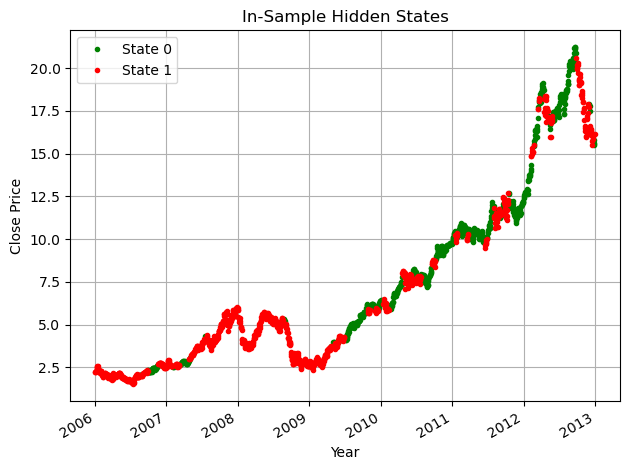

Plot for aapl


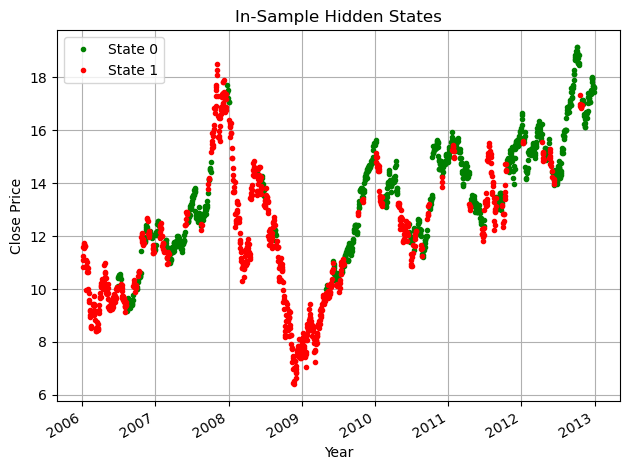

Plot for googl


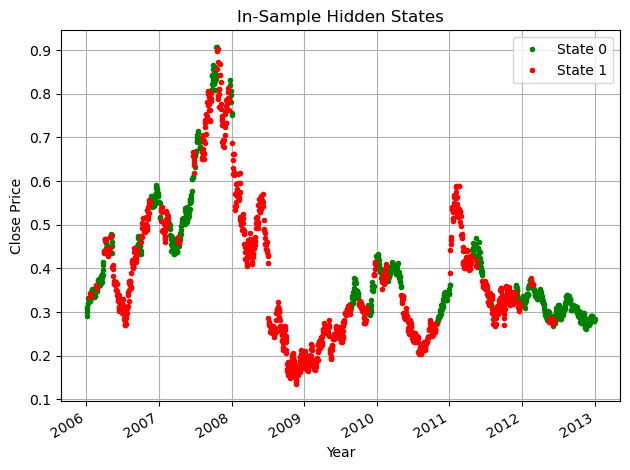

Plot for nvda


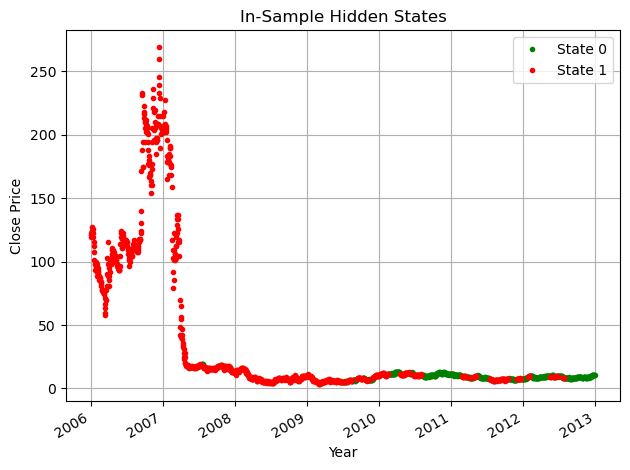

Plot for dal


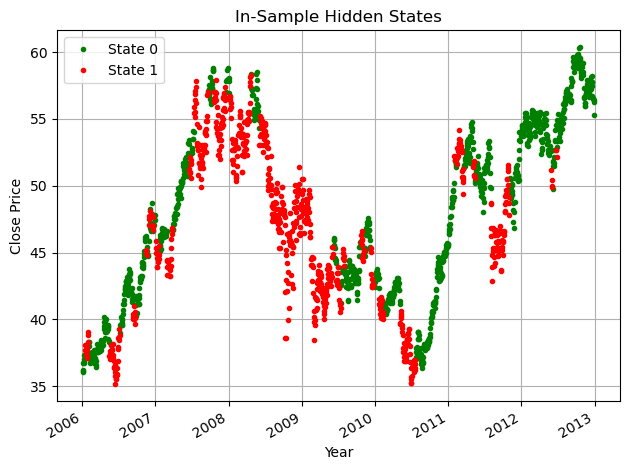

Plot for xom


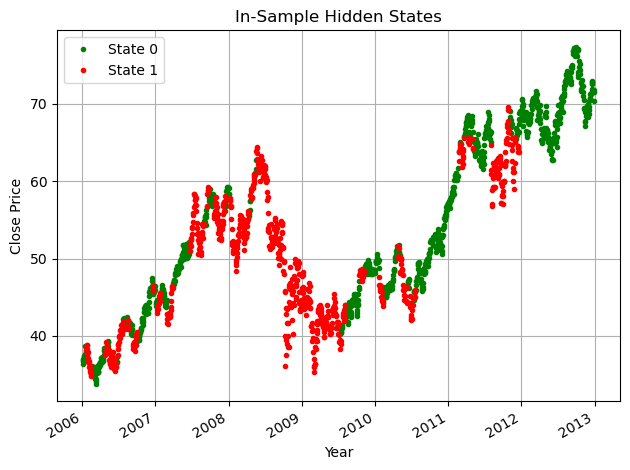

Plot for cvx


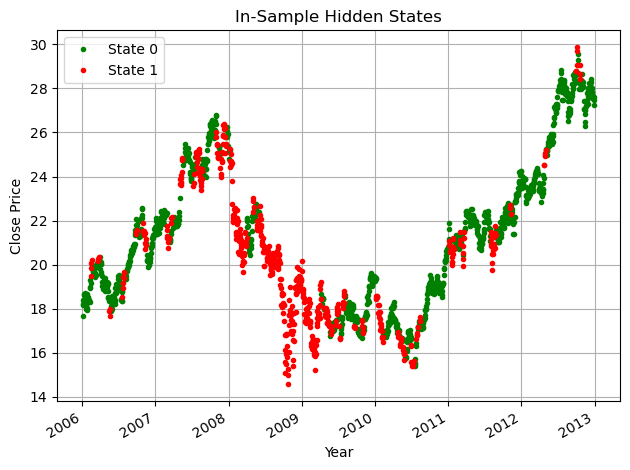

Plot for vz


In [76]:
for i in range(len(stocks)):
    stock = smooth_data_with_date[i]
    df= stock[stock["Date"].dt.year.isin(range(2006,2013))].reset_index(drop=True)
    df.set_index('Date', inplace=True)
    plot_in_sample_hidden_states(df)
    print(f"Plot for {stocks[i]}")

In [77]:
total=pd.concat(smooth_data_with_date).reset_index(drop=True)
total.to_csv('stock_hmm_output_kalman.csv')